In [1]:
import os
import numpy as np
import numpy.random as npr
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
#plt.switch_backend('agg')

from scipy.integrate import odeint

keras = tf.keras
tf.compat.v1.enable_eager_execution()

#from neural_ode import NeuralODE

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
def SIR(z, t, beta, gamma):

    S, I, R = z

    dS = - beta * I * S / N 
    dI = beta * I * S / N - gamma * I
    dR = gamma * I 

    dzdt = [dS, dI, dR]
    return dzdt

# adattare il modello tempo-variabile -> così da considerare lockdown ecc? -> o con alcuni threshold

def plot_traj(trajectories, width = 1.):
    x1 = trajectories[:,0]
    x2 = trajectories[:,1]
    x3 = trajectories[:,2]
    s = plt.plot(x1, linewidth = width, label = 'Susceptible')
    i = plt.plot(x2, linewidth = width, label = 'Infected')
    r = plt.plot(x3, linewidth = width, label = 'Removed')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Simulation with R0 = %f' %R0 )
    plt.show()

    

In [3]:
data_size = 150
batch_time = 20   # da vedere cosa fa davvero
niters = 500
batch_size = 50  # da vedere cosa fa davvero

N = 10000000
infected_0 = N/10000
beta = 0.3  # farli time evolving?
gamma = 0.1

R0 = beta/gamma

In [4]:
t_grid = np.linspace(0, data_size, data_size)  # uniformly spaced data? -> even though advantage is learning with not uniformly spaced data
z0 = [N - infected_0, infected_0, 0] # initial conditions
true_yy = odeint(SIR, z0, t_grid, args=(beta, gamma))  # potrebbe aver senso tenerli in memoria se è lento

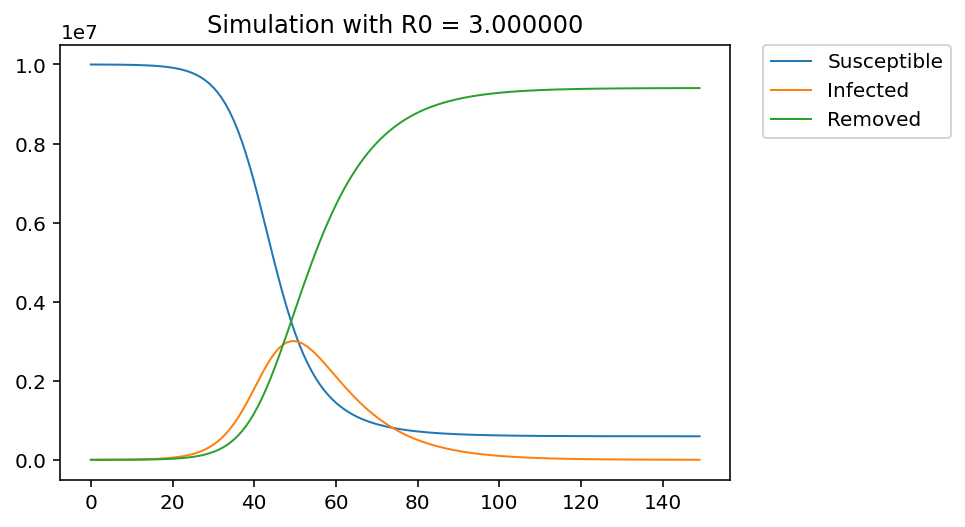

In [5]:
plot_traj(true_yy)

In [7]:
true_y = true_yy.copy()

from stochastic.processes.continuous import FractionalBrownianMotion

fbm = FractionalBrownianMotion(hurst=0.2, t= data_size)
# in questo modo è autocorrelato negativamente -> giorno da tanti tamponi seguito da giorno da pochi tamponi

noise = abs(N/100 * fbm.sample(data_size-1))
noise_2 = abs(N/100 * fbm.sample(data_size-1))


true_y[:,0] = abs(true_y[:,0] - noise)        
true_y[:,1] = abs(true_y[:,1] + noise - noise_2)
true_y[:,2] = N - true_y[:,0] - true_y[:,1]

# problema in realtà è che i suscettibili e i rimossi possono crescere/decrescere

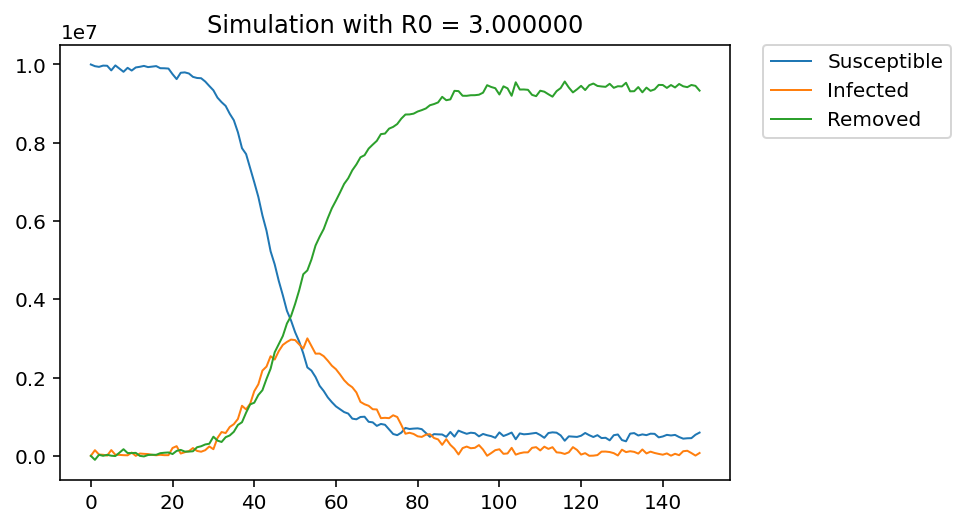

In [8]:
plot_traj(true_y)

In [9]:
sigma_s = np.std(true_yy[:,0:1])  
sigma_i = np.std(true_yy[:,1:2]) 
sigma_r = np.std(true_yy[:,2:3]) 

true_y[:, 0:1] = true_y[:, 0:1]/sigma_s
true_y[:, 1:2] = true_y[:, 1:2]/sigma_i
true_y[:, 2:3] = true_y[:, 2:3]/sigma_r

In [10]:
def get_batch():
    """Returns initial point and last point over sampled frament of trajectory"""
    starts = np.random.choice(np.arange(data_size - batch_time - 1, dtype=np.int64), batch_size, replace=False)
    # This randomly chooses from {0, 1, ... , data_size - batch_time - 1}, batch_size different elements
    batch_y0 = true_y[starts] 
    batch_yN = true_y[starts + batch_time]
    # The function returns a tensor composed by some y0 and the respective yN,
    # being y0 + DeltaT.
    return tf.cast(batch_y0, dtype=tf.float32), tf.cast(batch_yN, dtype=tf.float32)

In [383]:
layers = [1, 20, 20, 1]
def get_para_num():
    L = len(layers)
    para_num = 0
    for k in range(L-1):
        para_num = para_num + layers[k] * layers[k+1] + layers[k+1]
    return para_num

num_param = get_para_num()

t0 = t_grid[:batch_time][0]  # t0 = first element of t_grid
t1 = t_grid[:batch_time][-1]  # t1 = the element of t_grid at batch_time
t_in = np.linspace(t0, t1, 20)  # The time grid between t0 and t1

batch_y0, batch_yN = get_batch()  # Returns the first and the last y observed for each batch

In [334]:
from neural_ode import NeuralODE

In [ ]:
niters_pre = 300

class ODEModel_pre(tf.keras.Model):
    def __init__(self):
        super(ODEModel_pre, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param*3, 1], dtype=tf.float32)*0.01, dtype=tf.float32)

    def forward_pass(self, H, layers, W):
        num_layers = len(layers)
        W_seq = W

        for k in range(0,num_layers-2):
            W = W_seq[0:layers[k] * layers[k+1]]
            W = tf.reshape(W, (layers[k], layers[k+1]))
            W_seq = W_seq[layers[k] * layers[k+1]:]
            b = W_seq[0:layers[k+1]]
            b = tf.reshape(b, (1, layers[k+1]))
            W_seq = W_seq[layers[k+1]:]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))

        W = W_seq[0:layers[num_layers-2] * layers[num_layers-1]]
        W = tf.reshape(W, (layers[num_layers-2], layers[num_layers-1]))
        W_seq = W_seq[layers[num_layers-2] * layers[num_layers-1]:]
        b = W_seq[0:layers[num_layers-1]]
        b = tf.reshape(b, (1, layers[num_layers-1]))
        H = tf.add(tf.matmul(H, W), b)
        return H

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        h1 = h[:,0:1]
        h2 = h[:,1:2]
        h3 = h[:,2:3]

        w_NN = self.Weights[num_param:,:]

        NN_out = self.forward_pass(sigma_normal1 * h1, layers, w_NN)

        h_out1 = p11 + sigma_normal1 * p12 *h1 + sigma_normal2 * p13 *h2 + sigma_normal1**2 * p14*h1**2\
                + sigma_normal1 * sigma_normal2 * p15*h1*h2 + sigma_normal2**2 * p16*h2**2
        h_out2 = NN_out
        h_out3 = NN_out
        
        h_out = tf.concat([h_out1/sigma_normal1, h_out2/sigma_normal2], 1)
        return h_out


model_pre = ODEModel_pre()
neural_ode_pre = NeuralODE(model_pre, t_in)
optimizer = tf.compat.v1.train.AdamOptimizer(1e-1)

@tf.function
def compute_gradients_and_update_pre(batch_y0, batch_yN):
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode_pre.forward(batch_y0)
    with tf.GradientTape() as g_pre:
        g_pre.watch(pred_y)
        loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2) + tf.reduce_sum(input_tensor=tf.abs(model_pre.trainable_weights[0]))

    dLoss = g_pre.gradient(loss, pred_y)
    h_start, dfdh0, dWeights = neural_ode_pre.backward(pred_y, dLoss)
    optimizer.apply_gradients(zip(dWeights, model_pre.weights))
    return loss, dWeights

# Compile EAGER graph to static (this will be much faster)
#compute_gradients_and_update_pre = tfe.defun(compute_gradients_and_update_pre)

parameters_pre = np.zeros((para_num, 1))

for step in range(niters_pre):
    print(step)
    loss, dWeights = compute_gradients_and_update_pre(batch_y0, batch_yN)
    parameters_pre = model_pre.trainable_weights[0].numpy()

print(parameters_pre)

In [390]:
niters_pre = 300  # Number of iterations of the preconditioner

class ODEModel_pre(tf.keras.Model):
    def __init__(self):
        super(ODEModel_pre, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
    # Initializer: assign normally distributed random weights which are very close to zero

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        S = h[:, 0:1] * sigma_s
        I = h[:, 1:2] * sigma_i
        R = h[:, 2:3] * sigma_r
        

        # ma che sintassi di merda -> facciamolo adattativo

        p1 = self.Weights[0]
        p2 = self.Weights[1]
        p3 = self.Weights[2]
        p4 = self.Weights[3]
        p5 = self.Weights[4]

        dS = - p1 * I * S / N + p3 * S
        dI = p1 * I * S / N - p2 * I + p4 * I
        dR = p2 * I + p5 * R
        
        h_out = tf.concat([dS/sigma_s, dI/sigma_i, dR/sigma_r], 1)
        return h_out


model_pre = ODEModel_pre()  
neural_ode_pre = NeuralODE(model_pre, t_in) 
optimizer = tf.compat.v1.train.AdamOptimizer(3e-2)  

In [398]:
@tf.function
def compute_gradients_and_update_pre(batch_y0, batch_yN):
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode_pre.forward(batch_y0)  # Predict y using Runge-Kutta 4 for each y0 in batch_y0
    with tf.GradientTape() as g_pre:
        g_pre.watch(pred_y)
        loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2) + tf.reduce_sum(input_tensor=tf.abs(model_pre.trainable_weights[0]))
        # This step is computing the loss function
    dLoss = g_pre.gradient(loss, pred_y)  # Here we compute the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode_pre.backward(pred_y, dLoss)  # Here we compute the dWeights
    optimizer.apply_gradients(zip(dWeights, model_pre.weights))  # Here we update the weights
    return loss, dWeights

parameters_pre = np.zeros((para_num, 1))

for step in tqdm(range(niters_pre)):
    loss, dWeights = compute_gradients_and_update_pre(batch_y0, batch_yN)
    parameters_pre = model_pre.trainable_weights[0].numpy()
print(parameters_pre)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:42<00:00,  2.93it/s]

[[ 0.24935517]
 [ 0.10990662]
 [-0.00076708]
 [ 0.02581052]
 [-0.00107118]]


In [399]:
initial_weight = parameters_pre  # We initialize the weights with the parameters found in preconditioning
print(initial_weight.shape, "here")


class ODEModel(tf.keras.Model):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
        # Initializer, initializes the weight to normal random variables with sd = 0.01

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        S = h[:, 0:1] * sigma_s
        I = h[:, 1:2] * sigma_i
        R = h[:, 2:3] * sigma_r
        

        # ma che sintassi di merda -> facciamolo adattativo

        p1 = self.Weights[0]
        p2 = self.Weights[1]
        p3 = self.Weights[2]
        p4 = self.Weights[3]
        p5 = self.Weights[4]

        dS = - p1 * I * S / N + p3 * S
        dI = p1 * I * S / N - p2 * I + p4 * I
        dR = p2 * I + p5 * R
        
        h_out = tf.concat([dS/sigma_s, dI/sigma_i, dR/sigma_r], 1)
        return h_out


model = ODEModel()
neural_ode = NeuralODE(model, t=t_in)  # We assign to NeuralODE the just created model and the time grid  between t0 and t1

@tf.function
def compute_gradients_and_update(batch_y0, batch_yN): 
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode.forward(batch_y0)  # This finds the predicted yNs
    with tf.GradientTape() as g:
        g.watch(pred_y)
        loss = tf.reduce_sum(input_tensor=(pred_y - batch_yN)**2)  # This creates the loss function

    dLoss = g.gradient(loss, pred_y)  # This computes the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode.backward(pred_y, dLoss)  # This applies the gradient descent to find
    # the updates for the weights

    return loss, dWeights

(5, 1) here


In [ ]:
def kinetic_energy(V, loggamma_v, loglambda_v):
    q = (np.sum(-V**2)/mom_theta - loggamma_v**2/mom_gamma - loglambda_v**2/mom_lambda)/2.0
    return q


def compute_gradient_param(dWeights, loggamma, loglambda, batch_size, para_num):
    WW = model.trainable_weights[0].numpy()
    dWeights = np.exp(loggamma)/2.0 * dWeights + np.exp(loglambda) * np.sign(WW - w_means)
    return dWeights


def compute_gradient_hyper(loss, weights, loggamma, loglambda, batch_size, para_num):
    grad_loggamma = np.exp(loggamma) * (loss/2.0 + 1.0) - (batch_size/2.0 + 1.0)
    grad_loglambda = np.exp(loglambda) * (np.sum(np.abs(weights - w_means)) + 1.0) - (para_num + 1.0)
    # This somehow computes the gradient of the hyper parameters in order to update them from step to step

    return grad_loggamma, grad_loglambda


def compute_Hamiltonian(loss, weights, loggamma, loglambda, batch_size, para_num):
    H = np.exp(loggamma)*(loss/2.0 + 1.0) + np.exp(loglambda)*(np.sum(np.abs(weights - w_means)) + 1.0) \
             - (batch_size/2.0 + 1.0) * loggamma - (para_num + 1.0) * loglambda
    return H

def leap_frog(v_in, w_in, loggamma_in, loglambda_in, loggamma_v_in, loglambda_v_in):
    # Leap frog step for Hamiltonian Monte Carlo

    model.trainable_weights[0].assign(w_in)
    v_new = v_in
    loggamma_v_new = loggamma_v_in
    loglambda_v_new = loglambda_v_in

    loggamma_new = loggamma_in
    loglambda_new = loglambda_in
    w_new = w_in

    for m in range(L):
        loss, dWeights = compute_gradients_and_update(batch_y0, batch_yN) # evaluate the gradient

        dWeights = np.asarray(dWeights[0])  # make the gradient to be numpy array
        dWeights = compute_gradient_param(dWeights, loggamma_new, loglambda_new, batch_size, para_num)
        grad_loggamma, grad_loglambda = compute_gradient_hyper(loss, w_new, loggamma_new, loglambda_new, batch_size, para_num)

        loggamma_v_new = loggamma_v_new - epsilon/2*grad_loggamma  # Computation of new velocities
        loglambda_v_new = loglambda_v_new - epsilon/2*grad_loglambda  # 2nd component of velocity
        v_new = v_new - epsilon/2*(dWeights)  # 3rd component of velocity
        w_new = model.trainable_weights[0].numpy() + epsilon / mom_theta * v_new  # updating of x_1
        model.trainable_weights[0].assign(w_new)  # Assignment
        loggamma_new = loggamma_new + epsilon / mom_gamma * loggamma_v_new  # Updating of x_2
        loglambda_new = loglambda_new + epsilon / mom_lambda * loglambda_v_new  # Updating of x_3

        # Second half of the leap frog
        loss, dWeights = compute_gradients_and_update(batch_y0, batch_yN)
        dWeights = np.asarray(dWeights[0])
        dWeights = compute_gradient_param(dWeights, loggamma_new, loglambda_new, batch_size, para_num)
        grad_loggamma, grad_loglambda = compute_gradient_hyper(loss, w_new, loggamma_new, loglambda_new, batch_size, para_num)

        v_new = v_new - epsilon/2*(dWeights)  # Updating of new velocities
        loggamma_v_new = loggamma_v_new - epsilon/2*grad_loggamma  # Updating of new velocities
        loglambda_v_new = loglambda_v_new - epsilon/2*grad_loglambda  # Updating of new velocities

    return v_new, w_new, loggamma_new, loglambda_new, loggamma_v_new, loglambda_v_new


neural_ode_test = NeuralODE(model, t=t_grid[0:data_size:20])
parameters = np.zeros((niters, para_num))  # book keeping the parameters
loggammalist = np.zeros((niters, 1))  # book keeping the loggamma
loglambdalist = np.zeros((niters, 1))  # book keeping the loggamma
loglikelihood = np.zeros((niters, 1))  # book keeping the loggamma
mom_theta = 0.15  # Momentum for the Hamiltonian Monte Carlo for theta parameters
mom_lambda = 0.01  # Momentum for the Hamiltonian Monte Carlo for lambda parameters
mom_gamma = 0.01  # Momentum for the Hamiltonian Monte Carlo for gamma parameters
L = 15  # leap frog step number
epsilon = 0.001  # leap frog step size  0.001
epsilon_max = 0.0002    # max 0.001  0.0002
epsilon_min = 0.0002    # max 0.001  0.0002
acc_rate = 0  # Used to compute and display the acceptance rate of the candidates
w_means = np.array([0, 0, 0, 0, 0], dtype=np.float32)  # A priori means of parameters of the model
w_means = w_means.reshape(5, 1)

def compute_epsilon(step):
    # This will compute the epsilon to use in the leapfrog which is different for every step. It decreases
    # with the steps increasing in number
    coefficient = np.log(epsilon_max/epsilon_min)
    return epsilon_max * np.exp(- step * coefficient / niters)


# initial weight
w_temp = initial_weight  # The one we found from the preconditioner
print("initial_w", w_temp)
loggamma_temp = 4. + np.random.normal()
loglambda_temp = np.random.normal()

model.trainable_weights[0].assign(w_temp)  # We assign to the weights of the model, the ones we found through
# the pre conditioner. Remember that the initial weights set by the initializer were random distributed according
# to a Gaussian with 0 mean and 0.01 sd.
loss_original, _ = compute_gradients_and_update(batch_y0, batch_yN)  # Compute the initial Hamiltonian

loggamma_temp = np.log(batch_size / loss_original)  # We define an initial guess for loggamma ?? Why defined as such?

print("This is the initial guess", loggamma_temp, "with loss", loss_original)
if loggamma_temp > 6.:
    loggamma_temp = 6.
    epsilon_max = 0.0002
    epsilon_min = 0.0002

# training steps
for step in tqdm(range(niters)):

    epsilon = compute_epsilon(step)  # Compute the adaptive epsilon for the steps
    v_initial = np.sqrt(mom_theta)*np.random.randn(para_num, 1)  # initialize the velocity
    loggamma_v_initial = np.sqrt(mom_gamma)*np.random.normal()
    loglambda_v_initial = np.sqrt(mom_lambda)*np.random.normal()

    loss_initial, _ = compute_gradients_and_update(batch_y0, batch_yN)  # compute the initial Hamiltonian
    # This line uses the weights of the preconditioner (see line 303) to compute the loss function with those
    loss_initial = compute_Hamiltonian(loss_initial, w_temp, loggamma_temp, loglambda_temp, batch_size, para_num)
    # Then it computes the Hamiltonian

    v_new, w_new, loggamma_new, loglambda_new, loggamma_v_new, loglambda_v_new = \
                            leap_frog(v_initial, w_temp, loggamma_temp, loglambda_temp, loggamma_v_initial, loglambda_v_initial)

    # Then the leapfrog is applied in order to update the parameters and the hyper parameters and to further
    # optimize the weights estimation (L steps of leapfrog at a time)

    # compute the final Hamiltonian, using the updated sampled weights found through leapfrog
    loss_finial, _ = compute_gradients_and_update(batch_y0, batch_yN)
    loss_finial = compute_Hamiltonian(loss_finial, w_new, loggamma_new, loglambda_new, batch_size, para_num)

    # making decisions
    p_temp = np.exp(-loss_finial + loss_initial + \
                    kinetic_energy(v_new, loggamma_v_new, loglambda_v_new) - kinetic_energy(v_initial, loggamma_v_initial, loglambda_v_initial))

    p = min(1, p_temp)
    p_decision = np.random.uniform()
    if p > p_decision:
        parameters[step:step+1, :] = np.transpose(w_new)  # Parameters are updated
        w_temp = w_new
        loggammalist[step, 0] = loggamma_new
        loglambdalist[step, 0] = loglambda_new
        loglikelihood[step, 0] = loss_finial
        loggamma_temp = loggamma_new
        loglambda_temp = loglambda_new
        acc_rate += 1
    else:
        parameters[step:step+1, :] = np.transpose(w_temp)  # New parameters are not updated
        model.trainable_weights[0].assign(w_temp)
        loggammalist[step, 0] = loggamma_temp
        loglambdalist[step, 0] = loglambda_temp
        loglikelihood[step, 0] = loss_initial

    #print('Probability of acceptance: ', p)
    #print('Accepted: ', p > p_decision)

print('Acceptance rate: ', acc_rate/niters)

np.save('parameters', parameters)  # The Monte Carlo chain of the parameters
np.save('loggammalist', loggammalist)  # The Monte Carlo chain of loggamma
np.save('loglikelihood', loglikelihood)  # The Monte Carlo chain of losses

np.savetxt("data_weights.csv", parameters, delimiter=',')
np.savetxt("data_loggammalist.csv", loggammalist, delimiter=',')
np.savetxt("data_loglikelihood.csv", loglikelihood, delimiter=',')
np.savetxt("data_loglambda.csv", loglambdalist, delimiter=',')

initial_w [[ 0.24935517]
 [ 0.10990662]
 [-0.00076708]
 [ 0.02581052]
 [-0.00107118]]


  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

This is the initial guess 0.9579258 with loss tf.Tensor(19.184395, shape=(), dtype=float32)


 29%|███████████████████████▎                                                        | 146/500 [11:27<27:22,  4.64s/it]